In [108]:
import sys
if '/usr/users/vogg/.conda/envs/mktrack/lib/python3.8/site-packages' not in sys.path:
    sys.path.insert(0, '/usr/users/vogg/.conda/envs/mktrack/lib/python3.8/site-packages')
    sys.path.insert(0, '/usr/users/vogg/monkey-tracking-in-the-wild/src')
    sys.path.insert(0, '/usr/users/vogg/monkey-tracking-in-the-wild/src/lib')
    
#import logging
import os
import re
import motmetrics as mm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import itertools

import _init_paths
#from lib.opts import opts
from tracking_utils.utils import mkdir_if_missing
#from lib.tracking_utils.log import logger
import datasets.jde as datasets
from track import eval_seq

In [109]:
def read_gt_results(filename):

    results_dict = dict()
    files = os.listdir(filename)
    files = [file for file in files if not file.startswith(".")]
    files.sort()

    for i, file in enumerate(files):
        with open(filename + file, 'r') as f:
            for line in f.readlines():
                linelist = line.split(" ")
                fid = i+1

                results_dict.setdefault(fid, list())
                
                #convert center, width, height to tlwh
                linelist[2] = (float(linelist[2]) - float(linelist[4])/2) * 1920
                linelist[3] = (float(linelist[3]) - float(linelist[5])/2) * 1080
                linelist[4] = float(linelist[4]) * 1920
                linelist[5] = float(linelist[5]) * 1080
                
                score = float(1)
                tlwh = tuple(map(float, linelist[2:6]))
                target_id = int(linelist[1])
                results_dict[fid].append((tlwh, target_id, score))
    return(results_dict)

def read_mot_results(filename):
    results_dict = dict()
    if os.path.isfile(filename):
        with open(filename, 'r') as f:
            for line in f.readlines():
                linelist = line.split(',')
                fid = int(linelist[0])
                if fid < 1:
                    continue
                results_dict.setdefault(fid, list())

                box_size = float(linelist[4]) * float(linelist[5])
                
                score = float(linelist[6])

                tlwh = tuple(map(float, linelist[2:6]))
                target_id = int(linelist[1])

                results_dict[fid].append((tlwh, target_id, score))

    return results_dict



### Define evaluation sequences

In [111]:
seqs = ['VID_20210223_123630_0', 'VID_20210223_123817_0', 'VID_20210228_154053_0', 
        'VID_20210224_114038_0', 'VID_20210301_105722_0', #'VID_20210228_153846_0', 'VID_20210301_143635_0', 'VID_20210301_145312_0'
         'VID_20210301_151229_0', 'VID_20210302_103307_0', 'VID_20210302_103130_0']

seqs = ['VID_20210301_105722_0', 'VID_20210223_123630_0', 'VID_20210227_133440_0',
        'VID_20210228_154053_0', 'VID_20210302_103130_0', 'VID_20210301_151229_0',
        #'VID_20210228_160721_0', 'VID_20210224_115455_0', 'VID_20210224_115729_0','VID_20210301_143635_0',
        'VID_20210223_123817_0', 'VID_20210301_145312_0', 'VID_20210228_153846_0',
        'VID_20210224_114038_0', 'VID_20210223_123854_0', 'VID_20210228_153942_0',
         'VID_20210302_103307_0', 'VID_20210227_133251_0']


#seqs = ['Eval' + str(i) for i in range(8,20)]

#seqs = ['VID_20210301_105722_0', 'VID_20210223_123630_0', 'VID_20210227_133440_0', 'VID_20210228_154053_0', 'VID_20210302_103130_0', 
#        'VID_20210301_151229_0', 'VID_20210228_160721_0', 'VID_20210224_114038_0', 'VID_20210224_115729_0', 'VID_20210223_123817_0',
#        'VID_20210301_145312_0', 'VID_20210228_153846_0', 'VID_20210224_115455_0', 'VID_20210223_123854_0', 'VID_20210228_153942_0',
#        'VID_20210301_143635_0', 'VID_20210302_103307_0', 'VID_20210227_133251_0']


In [112]:
def evaluate_model(model, seqs, path = "methods_paper/", animal = "macaque"):
    
    accs = []
    
    for seq in seqs:
        gt_results = read_gt_results(f"/usr/users/agecker/datasets/{animal}_videos_eval/{seq}/labels_with_ids/")
        mot_results = read_mot_results(f"../videos/{path}{seq}/{model}/results.txt")
        
        acc = mm.MOTAccumulator(auto_id = True)

        for frame_id in range(len(gt_results)):
            frame_id = frame_id + 1
            gt_objs = gt_results.get(frame_id, [])
            trk_objs = mot_results.get(frame_id, [])
            if gt_objs == [] or trk_objs == []:
                continue
            else:
                gt_tlwhs, gt_ids, _ = zip(*gt_objs)
                trk_tlwhs, trk_ids, _ = zip(*trk_objs)

                iou_distance = mm.distances.iou_matrix(gt_tlwhs, trk_tlwhs, max_iou=0.5)
                acc.update(gt_ids, trk_ids, iou_distance)

        accs.append(acc)

    metrics=('mota', 'num_switches', 'idf1')
    mh = mm.metrics.create()

    summary = mh.compute_many(
                accs,
                metrics=metrics,
                names=seqs,
                generate_overall=True
            )
    
    return(summary)

### Evaluate one model

In [113]:
#With overall
model = 'lemur_250'
evaluate_model(model, seqs, path = "methods_paper/", animal = "lemur")


FileNotFoundError: [Errno 2] No such file or directory: '/usr/users/agecker/datasets/lemur_videos_eval/VID_20210301_105722_0/labels_with_ids/'

In [30]:
#With overall
model = 'test'
evaluate_model(model, seqs, path = "methods_paper/")

,mota,num_switches,idf1
VID_20210301_105722_0,0.936262,0,0.967286
VID_20210223_123630_0,0.716480,4,0.784117
VID_20210227_133440_0,0.861111,1,0.716000
VID_20210228_154053_0,0.990566,0,0.995261
VID_20210302_103130_0,0.795043,1,0.804646
VID_20210301_151229_0,1.000000,0,1.000000
VID_20210223_123817_0,0.761861,1,0.864480
VID_20210301_145312_0,0.744246,0,0.871630
VID_20210228_153846_0,0.930748,2,0.861732
VID_20210224_114038_0,0.929191,0,0.965806


In [114]:
#With overall
model = 'macaquepose_1_150'
evaluate_model(model, seqs, path = "methods_paper/")

,mota,num_switches,idf1
VID_20210301_105722_0,0.611542,0,0.779678
VID_20210223_123630_0,0.718575,10,0.689937
VID_20210227_133440_0,0.746032,1,0.754352
VID_20210228_154053_0,0.946541,0,0.972713
VID_20210302_103130_0,0.726406,0,0.841699
VID_20210301_151229_0,1.000000,0,1.000000
VID_20210223_123817_0,0.800182,1,0.870448
VID_20210301_145312_0,0.924359,0,0.961960
VID_20210228_153846_0,0.936288,0,0.968144
VID_20210224_114038_0,0.958092,0,0.979476


### Compare many models

In [115]:
#['mcqcp2_' + str(elem) for elem in list(range(60,161,10))] + \
models = ['mcqcp' + str(elem) for elem in [130, 200, 210]] + \
    ['mcqcpz' + str(elem) for elem in [200, 140, 270]] + \
    ['mcqcp2_'+ str(elem) for elem in [240, 200, 190]] + \
    ['mcq'+ str(elem) for elem in [210, 280, 290]] + \
    ['oms' + str(elem) for elem in [2,4,6]] + \
    ['mcqcp32_' + str(elem) for elem in [220, 290, 150]]
models = ['mcqcp_1e4_' + str(elem) for elem in list(range(10, 251, 10))] + \
    ['mcqcp_z_1e4_' + str(elem) for elem in list(range(10, 251, 10))] + \
    ['mcqpose_1e4_' + str(elem) for elem in list(range(10, 501, 10))] +\
    ['mcqcpwild_1e4_' + str(elem) for elem in list(range(10, 251, 10))]

models = [f'{model}_{str(seed)}_{str(epoch)}' for model in ['macaquepose', 'macaquecpw', 'macaquecp'] for seed in [1,2,3] for epoch in range(10,260,10)]
#print(models)

In [116]:
#Compare many models
all_models = []

for model in models:
    summary = evaluate_model(model, seqs).iloc[-1:,:]
    summary.index = [model]
    all_models.append(summary)
    

output = pd.concat(all_models)
output

,mota,num_switches,idf1
macaquepose_1_10,0.722439,19,0.824798
macaquepose_1_20,0.693866,11,0.802242
macaquepose_1_30,0.755267,20,0.820409
macaquepose_1_40,0.708100,20,0.801995
macaquepose_1_50,0.783654,15,0.851767
...,...,...,...
macaquecp_3_210,0.824935,16,0.876283
macaquecp_3_220,0.828232,18,0.882933
macaquecp_3_230,0.814827,20,0.873832
macaquecp_3_240,0.822578,18,0.876287


In [121]:
output['epoch'] = output.index.str.split("_").map(lambda x: x[-1]).astype(float)
output['model'] = output.index.str.split("_").map(lambda x: x[0])
output['seed'] = output.index.str.split("_").map(lambda x: x[1])
#output.loc[output.pretrain == "1e4", "seed"] = "human"

#get moving average
output['mota_roll'] = output.groupby(['model','seed']).mota.transform(lambda s: s.rolling(4, min_periods=1).mean())
output['idf1_roll'] = output.groupby(['model','seed']).idf1.transform(lambda s: s.rolling(4, min_periods=1).mean()) 
output['num_switches_roll'] = output.groupby(['model','seed']).num_switches.transform(lambda s: s.rolling(4, min_periods=1).mean()) 

output

,mota,num_switches,idf1,epoch,model,seed,mota_roll,idf1_roll,num_switches_roll
macaquepose_1_10,0.722439,19,0.824798,10.0,macaquepose,1,0.722439,0.824798,19.000000
macaquepose_1_20,0.693866,11,0.802242,20.0,macaquepose,1,0.708152,0.813520,15.000000
macaquepose_1_30,0.755267,20,0.820409,30.0,macaquepose,1,0.723857,0.815816,16.666667
macaquepose_1_40,0.708100,20,0.801995,40.0,macaquepose,1,0.719918,0.812361,17.500000
macaquepose_1_50,0.783654,15,0.851767,50.0,macaquepose,1,0.735222,0.819103,16.500000
...,...,...,...,...,...,...,...,...,...
macaquecp_3_210,0.824935,16,0.876283,210.0,macaquecp,3,0.825809,0.877574,13.750000
macaquecp_3_220,0.828232,18,0.882933,220.0,macaquecp,3,0.826185,0.879317,15.250000
macaquecp_3_230,0.814827,20,0.873832,230.0,macaquecp,3,0.824557,0.879831,16.250000
macaquecp_3_240,0.822578,18,0.876287,240.0,macaquecp,3,0.822643,0.877334,18.000000


In [122]:
output.iloc[14, :]

mota                    0.808198
num_switches                  15
idf1                    0.860525
epoch                      150.0
model                macaquepose
seed                           1
mota_roll               0.806622
idf1_roll                0.86087
num_switches_roll           15.0
Name: macaquepose_1_150, dtype: object

In [125]:
output.to_csv("/usr/users/vogg/monkey-tracking-in-the-wild/eval.csv")

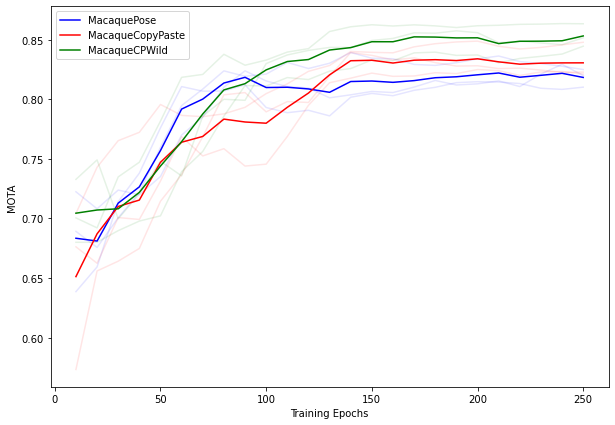

In [124]:
metric = "mota_roll"

subset1 = output[(output.seed == "1") & (output.model == "macaquepose")]
subset2 = output[(output.seed == "2") & (output.model == "macaquepose")]
subset3 = output[(output.seed == "3") & (output.model == "macaquepose")]
subset4 = output[(output.seed == "1") & (output.model == "macaquecp")]
subset5 = output[(output.seed == "2") & (output.model == "macaquecp")]
subset6 = output[(output.seed == "3") & (output.model == "macaquecp")]
subset7 = output[(output.seed == "1") & (output.model == "macaquecpw")]
subset8 = output[(output.seed == "2") & (output.model == "macaquecpw")]
subset9 = output[(output.seed == "3") & (output.model == "macaquecpw")]

subset_summ = output.groupby(['model', 'epoch'])[metric].mean().reset_index()
subset10 = subset_summ[subset_summ.model == 'macaquepose']
subset11 = subset_summ[subset_summ.model == 'macaquecp']
subset12 = subset_summ[subset_summ.model == 'macaquecpw']

fig, ax = plt.subplots(figsize=(10, 7))
line1,  = ax.plot(subset1.epoch, subset1[metric], c = "blue", alpha = 0.1)
line2,  = ax.plot(subset2.epoch, subset2[metric], c = "blue", alpha = 0.1)
line3,  = ax.plot(subset3.epoch, subset3[metric], c = "blue", alpha = 0.1)
line4,  = ax.plot(subset4.epoch, subset4[metric], c = "red", alpha = 0.1)
line5,  = ax.plot(subset5.epoch, subset5[metric], c = "red", alpha = 0.1)
line6,  = ax.plot(subset6.epoch, subset6[metric], c = "red", alpha = 0.1)
line7,  = ax.plot(subset7.epoch, subset7[metric], c = "green", alpha = 0.1)
line8,  = ax.plot(subset8.epoch, subset8[metric], c = "green", alpha = 0.1)
line9,  = ax.plot(subset9.epoch, subset9[metric], c = "green", alpha = 0.1)
line10,  = ax.plot(subset10.epoch, subset10[metric], c = "blue")
line11,  = ax.plot(subset11.epoch, subset11[metric], c = "red")
line12,  = ax.plot(subset12.epoch, subset12[metric], c = "green")
#ax.plot(output.epoch, 1 - (output.num_switches / (output.num_switches.max() * 2)))
ax.set_xlabel("Training Epochs")
ax.set_ylabel("MOTA")
ax.legend([line10, line11, line12], ['MacaquePose', 'MacaqueCopyPaste', 'MacaqueCPWild'])

In [63]:
subset10

,model,epoch,mota
30,pose,10.0,0.552535
31,pose,20.0,0.487984
32,pose,30.0,0.610561
33,pose,40.0,0.663668
34,pose,50.0,0.733609
35,pose,60.0,0.677744
36,pose,70.0,0.706949
37,pose,80.0,0.724394
38,pose,90.0,0.723293
39,pose,100.0,0.654788


### Compare Lemur models

In [98]:
models = [f'lemur_{str(epoch)}'  for epoch in range(10,260,10)]

#Compare many models
all_models = []

for model in models:
    summary = evaluate_model(model, seqs, path = "methods_paper/", animal = "lemur").iloc[-1:,:]
    summary.index = [model]
    all_models.append(summary)
    

output = pd.concat(all_models)
output

,mota,num_switches,idf1
lemur_10,0.549145,73,0.505864
lemur_20,0.614965,91,0.513196
lemur_30,0.585375,92,0.546023
lemur_40,0.686081,65,0.547514
lemur_50,0.676236,73,0.566929
lemur_60,0.640012,90,0.556426
lemur_70,0.725349,51,0.532021
lemur_80,0.711446,77,0.530444
lemur_90,0.742860,76,0.531362
lemur_100,0.646626,98,0.513563


In [99]:
output['epoch'] = output.index.str.split("_").map(lambda x: x[-1]).astype(float)
output['model'] = output.index.str.split("_").map(lambda x: x[0])
#output.loc[output.pretrain == "1e4", "seed"] = "human"

#get moving average
output['mota_roll'] = output.groupby(['model']).mota.transform(lambda s: s.rolling(5, min_periods=1).mean())
output['idf1_roll'] = output.groupby(['model']).idf1.transform(lambda s: s.rolling(5, min_periods=1).mean()) 
output['num_switches_roll'] = output.groupby(['model']).num_switches.transform(lambda s: s.rolling(5, min_periods=1).mean()) 

output

,mota,num_switches,idf1,epoch,model,mota_roll,idf1_roll,num_switches_roll
lemur_10,0.549145,73,0.505864,10.0,lemur,0.549145,0.505864,73.000000
lemur_20,0.614965,91,0.513196,20.0,lemur,0.582055,0.509530,82.000000
lemur_30,0.585375,92,0.546023,30.0,lemur,0.583162,0.521694,85.333333
lemur_40,0.686081,65,0.547514,40.0,lemur,0.608892,0.528149,80.250000
lemur_50,0.676236,73,0.566929,50.0,lemur,0.622361,0.535905,78.800000
lemur_60,0.640012,90,0.556426,60.0,lemur,0.640534,0.546017,82.200000
lemur_70,0.725349,51,0.532021,70.0,lemur,0.662611,0.549783,74.200000
lemur_80,0.711446,77,0.530444,80.0,lemur,0.687825,0.546667,71.200000
lemur_90,0.742860,76,0.531362,90.0,lemur,0.699181,0.543436,73.400000
lemur_100,0.646626,98,0.513563,100.0,lemur,0.693259,0.532763,78.400000


Text(0, 0.5, 'mota')

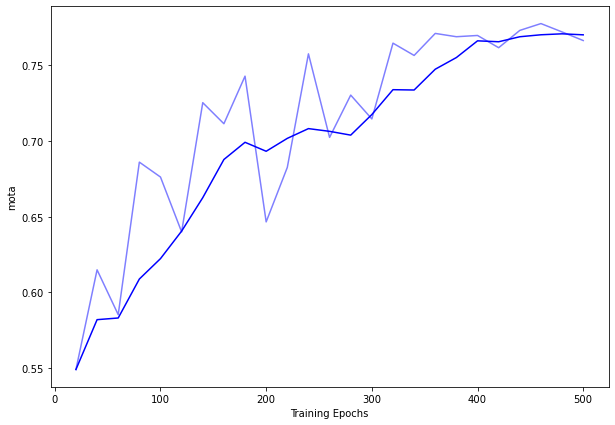

In [105]:
metric = "mota"


fig, ax = plt.subplots(figsize=(10, 7))
line1,  = ax.plot(output.epoch * 2, output[metric], c = "blue", alpha = 0.5)
line2,  = ax.plot(output.epoch * 2, output[f'{metric}_roll'], c = "blue")

#ax.plot(output.epoch, 1 - (output.num_switches / (output.num_switches.max() * 2)))
ax.set_xlabel("Training Epochs")
ax.set_ylabel(metric)

## Thresholds

We have four thresholds which can be tuned for a better detection / tracking result. We will tweak them with the currently best model mcq180.pth to see if we can improve performance even further.
- Confidence threshold (conf): what is the minimum heatmap confidence to accept something as a potential detection.
- similarity threshold (sim): When doing the linear matching, what is the minimum required similarity of a track to a new detection, so that they can be matched
- New track threshold (det): how confident does a detection have to be to form a new track in case it is not matched to any existing track
- New overlap threshold (overlap): how much can a detection overlap with an existing track and still form a new track

In [35]:
combs = []

for conf in [0.02]:
    for sim in [0.3]:
        for det in [0.3, 0.4, 0.5, 0.6, 0.7]:
            for overlap in [0.5]:
                combs.append("hrnet32"+str(conf)+"_"+str(sim)+"_"+str(det)+"_"+str(overlap))

In [38]:
all_models = []

for model in combs:
    summary = evaluate_model(model, seqs, path = "lemur_thresholds/").iloc[-1:,:]
    summary.index = [model]
    all_models.append(summary)
    

output = pd.concat(all_models)
output

FileNotFoundError: [Errno 2] No such file or directory: '/usr/users/agecker/datasets/macaque_videos/Eval8/labels_with_ids/'

In [28]:
summary = output
summary['index1'] = summary.index

summary['confidence'] = summary['index1'].str.split("_").map(lambda x: x[1]).astype(float)
summary['embedding_sim'] = summary['index1'].str.split("_").map(lambda x: x[2]).astype(float)
summary['new_det'] = summary['index1'].str.split("_").map(lambda x: x[4]).astype(float)

summary = summary.drop(columns = ['index1'])

IndexError: list index out of range

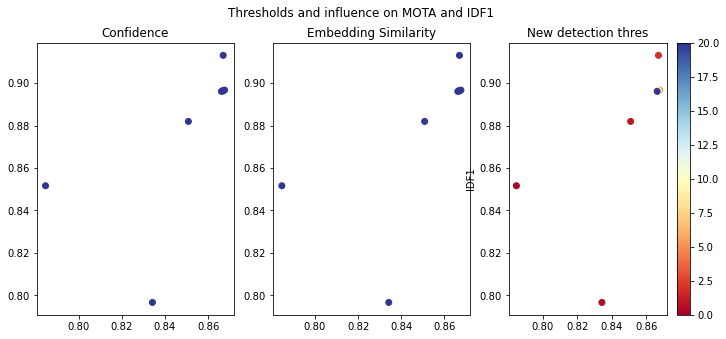

In [119]:
cm = plt.cm.get_cmap('RdYlBu')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,5))
fig.suptitle('Thresholds and influence on MOTA and IDF1')

ax1.scatter(summary.mota, summary.idf1, 
                 c = summary.confidence, cmap=cm, vmin = 0)
ax1.set_title("Confidence")

ax2.scatter(summary.mota, summary.idf1, 
                 c = summary.embedding_sim, cmap=cm, vmin = 0)
ax2.set_title("Embedding Similarity")

cm = ax3.scatter(summary.mota, summary.idf1, 
                 c = summary.new_det, cmap=cm, vmin = 0)
ax3.set_ylabel("IDF1")
ax3.set_title("New detection thres")

plt.colorbar(cm)